In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Config

In [2]:
# Số lượng xe
N = 500

# Tham số mô hình OVM
v_f_max = 2.0  # Tốc độ tối đa ngoài slowdown
x_c = 2.0      # Turning point
sensitivity = a = 2.5

dt = 1 / 128
steps = 50000

## Model

In [3]:
# ===== Hàm vận tốc tối ưu =====

# Vùng thường (có hệ số a)
def optimal_velocity_normal(delta_x, v_max, x_c, a):
    return 0.5 * v_max * (np.tanh(a * (delta_x - x_c)) + np.tanh(a * x_c))

# Vùng slowdown (ngầm định a = 1)
def optimal_velocity_slowdown(delta_x, v_max, x_c):
    return 0.5 * v_max * (np.tanh(delta_x - x_c) + np.tanh(x_c))

# ===== Hàm kiểm tra giới hạn tốc độ hiện tại =====

def get_speed_limit(pos, sections, v_f_max):
    """
    Trả về (v_max, is_slowdown) tương ứng với vị trí hiện tại
    """
    for zone in sections['slowdowns']:
        if zone['start'] <= pos <= zone['end']:
            return zone['v_max'], True
    return v_f_max, False

# ===== Hàm gia tốc chính =====

def acceleration(x, v, idx, sections, a, v_f_max, x_c):
    N = len(x)
    L = sections['L']
    
    # Tính delta_x với điều kiện tuần hoàn
    delta_x = x[(idx + 1) % N] - x[idx]
    if delta_x < 0:
        delta_x += L

    pos = x[idx] % L
    v_max, is_slowdown = get_speed_limit(pos, sections, v_f_max)

    if is_slowdown:
        V_opt = optimal_velocity_slowdown(delta_x, v_max, x_c)
    else:
        V_opt = optimal_velocity_normal(delta_x, v_max, x_c, a)

    return a * (V_opt - v[idx])


## Simulation

In [4]:
# Runge-Kutta bậc 4 cho hệ N phương trình
def rk4_step(x, v, dt, acc_fn, sections, a, v_f_max, x_c):
    N = len(x)
    L = sections['L']

    def acc_all(x_, v_):
        return np.array([acc_fn(x_, v_, i, sections, a, v_f_max, x_c) for i in range(N)])

    kx1 = dt * v
    kv1 = dt * acc_all(x, v)

    kx2 = dt * (v + 0.5 * kv1)
    kv2 = dt * acc_all((x + 0.5 * kx1) % L, v + 0.5 * kv1)

    kx3 = dt * (v + 0.5 * kv2)
    kv3 = dt * acc_all((x + 0.5 * kx2) % L, v + 0.5 * kv2)

    kx4 = dt * (v + kv3)
    kv4 = dt * acc_all((x + kx3) % L, v + kv3)

    x_next = (x + (kx1 + 2 * kx2 + 2 * kx3 + kx4) / 6) % L
    v_next = v + (kv1 + 2 * kv2 + 2 * kv3 + kv4) / 6

    return x_next, v_next

# Hàm mô phỏng chính
def simulate(N, steps, dt, acc_fn, x_init, v_init, sections, a, v_f_max, x_c, save_every=1000):
    x, v = x_init.copy(), v_init.copy()
    history = []

    print(f"[SIM] Bắt đầu mô phỏng trong {steps} bước...")
    print(f"[SIM] Số xe: {N} | Độ dài đường: {sections['L']} | save_every: {save_every}")

    for t in range(steps):
        x, v = rk4_step(x, v, dt, acc_fn, sections, a, v_f_max, x_c)

        if t % save_every == 0 or t == steps - 1:
            history.append((x.copy(), v.copy()))
            print(f"[SIM] Bước {t+1}/{steps} đã lưu trạng thái.")

        elif t % (steps // 10) == 0:
            print(f"[SIM] Đang chạy... {t+1}/{steps} ({(t+1)/steps:.0%})")

    print("[SIM] Mô phỏng hoàn tất.")
    return history

## Plot

In [ ]:
# Vẽ background cho các vùng slowdown
def shade_slowdowns(ax, sections, color='lightgray'):
    for s in sections['slowdowns']:
        ax.axvspan(s['start'], s['end'], color=color, alpha=0.3, label='Slowdown' if 'Slowdown' not in ax.get_legend_handles_labels()[1] else None)

# Vẽ velocity profile tại một thời điểm
def plot_velocity(x, v, sections, title="Velocity Profile"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(x, v, s=5, color='blue', label='Velocity')
    shade_slowdowns(ax, sections)
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Vẽ headway profile
def plot_headway(x, sections, title="Headway Profile"):
    x_sorted = np.sort(x)
    headway = np.diff(np.concatenate((x_sorted, [x_sorted[0] + sections['L']])))
    pos = x_sorted

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(pos, headway, s=5, color='green', label='Headway')
    shade_slowdowns(ax, sections)
    ax.set_xlabel("Position")
    ax.set_ylabel("Headway")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ current vs density
def plot_current_vs_density(densities, currents, label="Simulated", theoretical_curve=None):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(densities, currents, 'o-', label=label)
    if theoretical_curve:
        dx_vals = np.linspace(1.0, 10.0, 200)
        J_vals = [theoretical_curve(dx) for dx in dx_vals]
        rho_vals = 1.0 / dx_vals
        ax.plot(rho_vals, J_vals, '--', label='Theoretical')
    ax.set_xlabel("Density")
    ax.set_ylabel("Current")
    ax.set_title("Fundamental Diagram (Current vs Density)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Vẽ jam length ratio vs density
def plot_jam_length_vs_density(densities, jam_ratios_dict, theoretical=None, title="Jam-Length Ratio vs Density"):
    fig, ax = plt.subplots(figsize=(8, 5))
    for label, ratios in jam_ratios_dict.items():
        ax.plot(densities, ratios, 'o-', label=label)

    if theoretical:
        ax.plot(densities, theoretical, 'k--', label="Theoretical")

    ax.set_xlabel("Density")
    ax.set_ylabel("Jam Length Ratio (lJ / L)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

## Utils

In [6]:
# Tính current: J = (1/N) * sum(v)
def compute_current(v):
    return np.mean(v)

# Tính density: rho = N / L
def compute_density(N, L):
    return N / L

# Tính headway: delta_xi = xi+1 - xi (có chu kỳ)
def compute_headways(x, L):
    x_sorted = np.sort(x)
    dx = np.diff(np.concatenate((x_sorted, [x_sorted[0] + L])))
    return dx, x_sorted

# Phát hiện vùng jam: đoạn liên tục có v_i < threshold (ví dụ 1.0)
def compute_jam_length(x, v, threshold, L):
    x_sorted_idx = np.argsort(x)
    x_sorted = x[x_sorted_idx]
    v_sorted = v[x_sorted_idx]

    in_jam = v_sorted < threshold
    jam_regions = []
    jam_len = 0.0

    start = None
    for i in range(len(in_jam)):
        if in_jam[i]:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i
                length = x_sorted[end - 1] - x_sorted[start]
                jam_regions.append(length)
                jam_len += length
                start = None

    # Nếu jam kéo dài đến cuối mảng
    if start is not None:
        length = (x_sorted[-1] + (L - x_sorted[-1] + x_sorted[0])) % L
        jam_regions.append(length)
        jam_len += length

    return jam_len, jam_regions

# Hàm lý thuyết: J = V(delta_x) / delta_x
def get_theoretical_current_fn(v_max, x_c, a):
    def J(dx):
        v = optimal_velocity_normal(dx, v_max, x_c, a)
        return v / dx
    return J


# Headway Profile - Velocity Profile

## Configuration 1 - Figure 3
LN1 = LN2 = LS1 = LS2 = L/4, rho = 0.25, vfmax = 2, vsmax = 1, a = 2.5

[INFO] Bắt đầu cấu hình mô phỏng cho Figure 3...
[INFO] Mô phỏng với N = 500, L = 2000.00, ρ = 0.25, dx_init = 4.0
[INFO] Bắt đầu chạy mô phỏng...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 2000.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[INFO] Mô phỏng hoàn tất.
[INFO] Vẽ biểu đồ velocity profile...


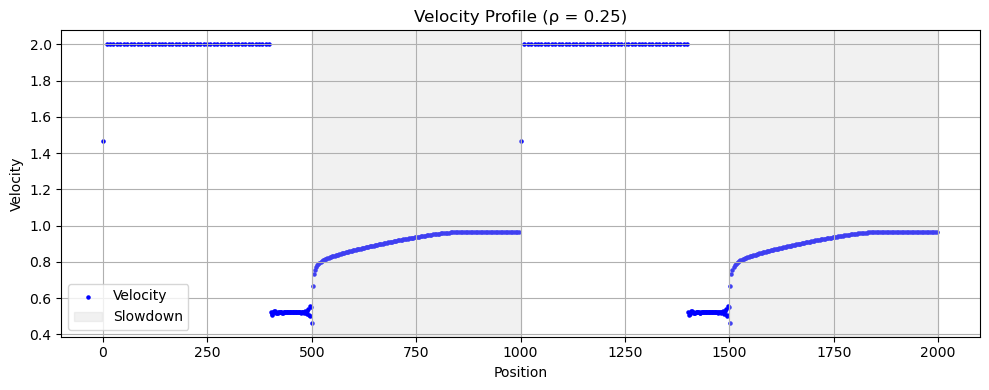

[INFO] Vẽ biểu đồ headway profile...


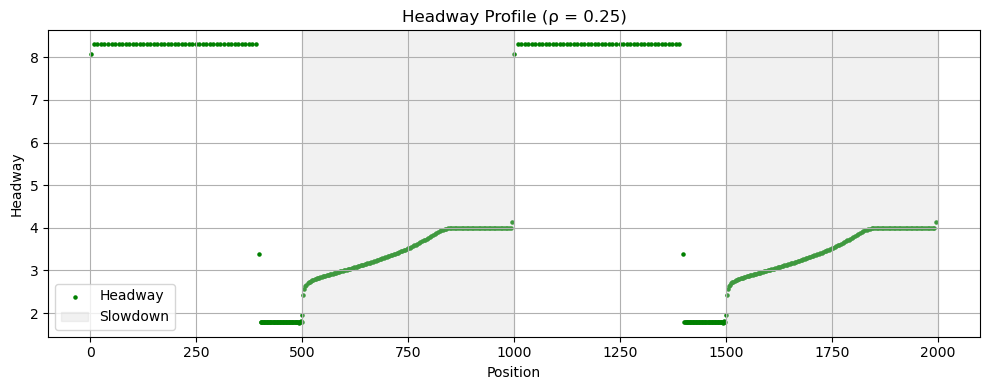

[INFO] Hoàn thành Figure 3.


In [ ]:
# === THIẾT LẬP CHO FIGURE 3 ===

print("[INFO] Bắt đầu cấu hình mô phỏng...")

# Mật độ ρ = 0.25 → headway = 1/ρ = 4.0 → L = N * 4.0
rho = 0.25
dx_init = 1 / rho
L = N * dx_init

# === Cấu hình lại vị trí xe ban đầu ===
x_init = np.linspace(0, L - dx_init, N)
v_init = np.zeros(N)

# === 2 slowdown sections bằng nhau ===
sections = {
    'L': L,
    'slowdowns': [
        {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.0},
        {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
    ]
}

print(f"[INFO] Mô phỏng với N = {N}, L = {L:.2f}, ρ = {rho}, dx_init = {dx_init}")
print("[INFO] Bắt đầu chạy mô phỏng...")

# === CHẠY MÔ PHỎNG ===
history = simulate(
    N=N,
    steps=steps,
    dt=dt,
    acc_fn=acceleration,
    x_init=x_init,
    v_init=v_init,
    sections=sections,
    a=a,
    v_f_max=v_f_max,
    x_c=x_c,
    save_every=steps
)

print("[INFO] Mô phỏng hoàn tất.")

# === LẤY KẾT QUẢ ===
x_final, v_final = history[-1]

print("[INFO] Vẽ biểu đồ headway profile...")
plot_headway(x_final, sections, title=f"Headway Profile (ρ = {rho})")

print("[INFO] Vẽ biểu đồ velocity profile...")
plot_velocity(x_final, v_final, sections, title=f"Velocity Profile (ρ = {rho})")

print("[INFO] Hoàn thành.")

## Configuration 1 - Figure 5
LN1 = LN2 = LS1 = LS2 = L/4, vfmax = 2, vsmax = 1, a = 2.5

[INFO] Simulating jam length ratio for Figure 5...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%

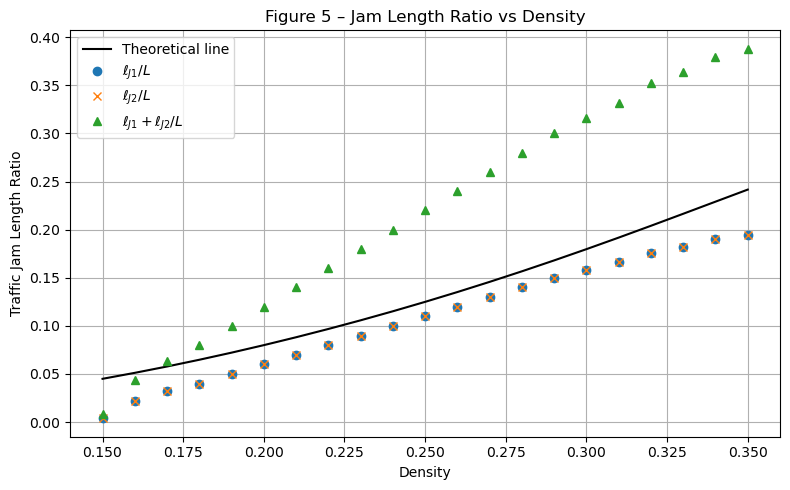

In [ ]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ_total_list = [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 5...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LN1 = LN2 = LS1 = LS2 = L/4
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.0},
            {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2 = 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 0.25 * L:
                j1 += 1
            elif 0.5 * L <= pos <= 0.75 * L:
                j2 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ_total_list.append((lJ1 + lJ2) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 5 – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Configuration 2 - Figure 6a:
LN1 = 0.35L, LN2 = 0.15L, LS1 = LS2 = L/4, rho = 0.3125, vfmax = 2, vsmax = 1, a = 2.5

[INFO] Bắt đầu cấu hình mô phỏng...
[INFO] Mô phỏng với N = 500, L = 1600.00, ρ = 0.3125, dx_init = 3.2
[INFO] Bắt đầu chạy mô phỏng...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 1600.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[INFO] Mô phỏng hoàn tất.
[INFO] Vẽ biểu đồ headway profile...


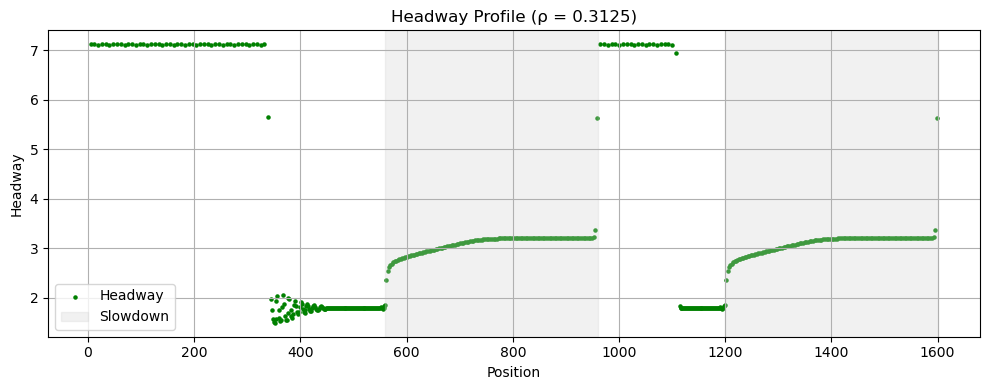

[INFO] Vẽ biểu đồ velocity profile...


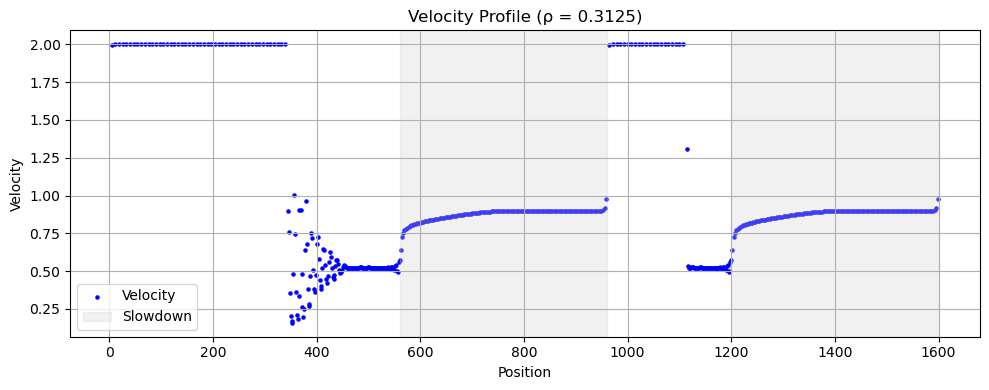

[INFO] Hoàn thành.


In [ ]:
# === THIẾT LẬP CHO FIGURE 6 ===

print("[INFO] Bắt đầu cấu hình mô phỏng...")

# Mật độ ρ = 0.3125 khi N = 500, L = 1600 → headway = 1/ρ → L = N / 0.3125
rho = 500 / 1600
dx_init = 1 / rho
L = N * dx_init

# === Cấu hình lại vị trí xe ban đầu ===
x_init = np.linspace(0, L - dx_init, N)
v_init = np.zeros(N)

# === 2 slowdown sections bằng nhau, N1 > N2 ===
sections = {
    'L': L,
    'slowdowns': [
        {'start': 0.35 * L, 'end': 0.6 * L, 'v_max': 1.0},
        {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
    ]
}

print(f"[INFO] Mô phỏng với N = {N}, L = {L:.2f}, ρ = {rho}, dx_init = {dx_init}")
print("[INFO] Bắt đầu chạy mô phỏng...")

# === CHẠY MÔ PHỎNG ===
history = simulate(
    N=N,
    steps=steps,
    dt=dt,
    acc_fn=acceleration,
    x_init=x_init,
    v_init=v_init,
    sections=sections,
    a=a,
    v_f_max=v_f_max,
    x_c=x_c,
    save_every=steps
)

print("[INFO] Mô phỏng hoàn tất.")

# === LẤY KẾT QUẢ ===
x_final, v_final = history[-1]

print("[INFO] Vẽ biểu đồ headway profile...")
plot_headway(x_final, sections, title=f"Headway Profile (ρ = {rho})")

print("[INFO] Vẽ biểu đồ velocity profile...")
plot_velocity(x_final, v_final, sections, title=f"Velocity Profile (ρ = {rho})")

print("[INFO] Hoàn thành.")

## Configuration 2 - Figure 6b:
LN1 = 0.35L, LN2 = 0.15L, LS1 = LS2 = L/4, vfmax = 2, vsmax = 1, a = 2.5

[INFO] Simulating jam length ratio for Figure 6b...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70

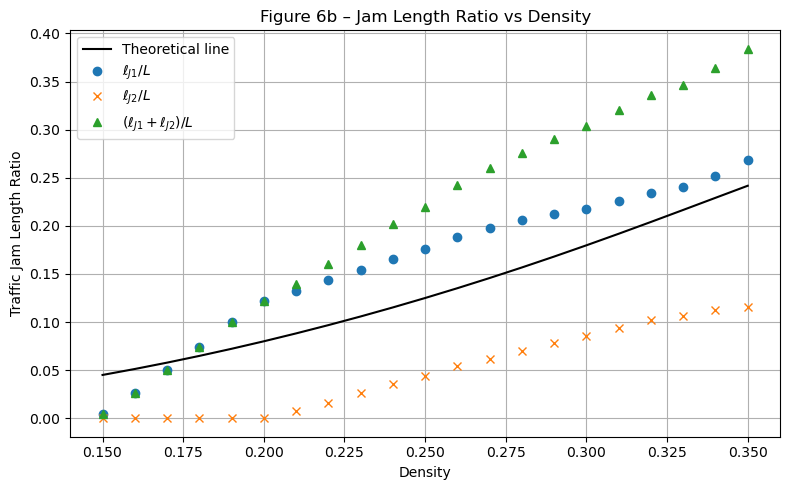

In [11]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ_total_list = [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 6b...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LN1 = 0.35L, LN2 = 0.15L, LS1 = 0.25L, LS2 = 0.25L
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 0.35 * L, 'end': 0.6 * L, 'v_max': 1.0},
            {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2 = 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 0.35 * L:
                j1 += 1
            elif 0.6 * L <= pos <= 0.75 * L:
                j2 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ_total_list.append((lJ1 + lJ2) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 6b – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Configuration 3 - Figure 7a:
LS1 = 0.35L, LS2 = 0.15L, LN1 = LN2 = L/4

[INFO] Simulating jam length ratio for Figure 7a...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70

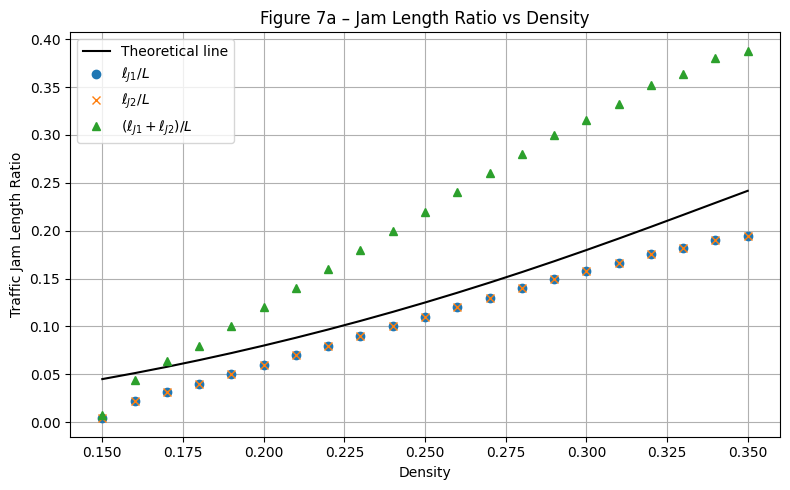

In [7]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ_total_list = [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 7a...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LN1 = 0.25L, LN2 = 0.25L, LS1 = 0.35L, LS2 = 0.15L
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 0.25 * L, 'end': 0.6 * L, 'v_max': 1.0},
            {'start': 0.85 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2 = 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 0.25 * L:
                j1 += 1
            elif 0.6 * L <= pos <= 0.85 * L:
                j2 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ_total_list.append((lJ1 + lJ2) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 7a – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## Configuration 4 - Figure 7b:
LN2 = LS2 = 0.35L, LN1 = LS1 = 0.15L

[INFO] Simulating jam length ratio for Figure 7b...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70

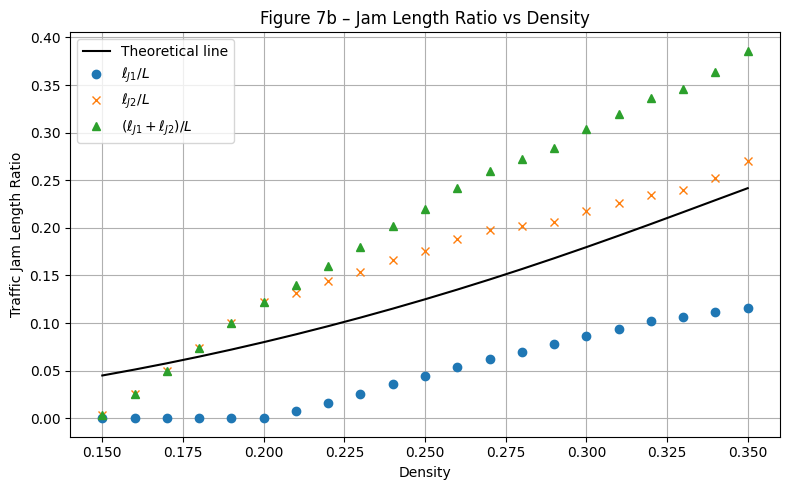

In [8]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ_total_list = [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 7b...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LN1 = 0.15L, LN2 = 0.35L, LS1 = 0.15L, LS2 = 0.35L
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 0.15 * L, 'end': 0.3 * L, 'v_max': 1.0},
            {'start': 0.65 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2 = 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 0.15 * L:
                j1 += 1
            elif 0.3 * L <= pos <= 0.65 * L:
                j2 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ_total_list.append((lJ1 + lJ2) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 7b – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Configuration 5 - Figure 8abc:
LS1 = LS2 = LN1 = LN2 = L/4, vs1max = 1.5, vs2max = 1.0, a = 2.5, vfmax = 2.0, rho = 0.16, 0.25, 0.33

[INFO] Bắt đầu cấu hình mô phỏng...
[INFO] Mô phỏng với N = 500, L = 3000.00, ρ = 0.16666666666666666, dx_init = 6.0
[INFO] Bắt đầu chạy mô phỏng...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3000.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[INFO] Mô phỏng hoàn tất.
[INFO] Vẽ biểu đồ headway profile...


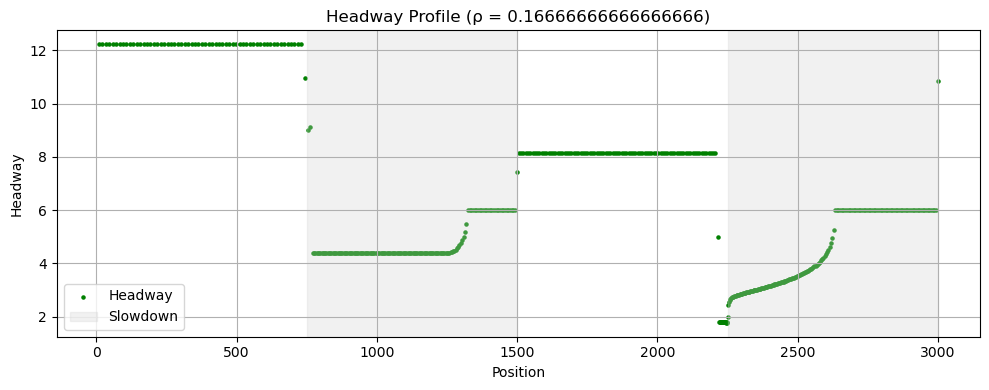

[INFO] Vẽ biểu đồ velocity profile...


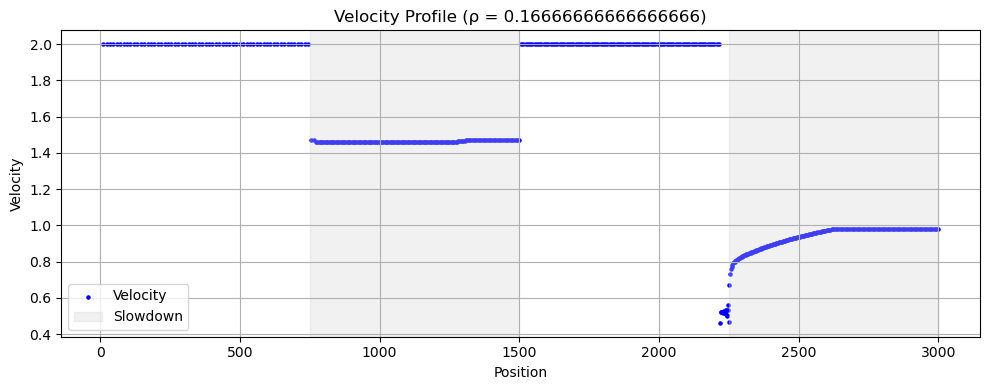

[INFO] Hoàn thành.


In [ ]:
# === THIẾT LẬP CHO FIGURE 8a ===

print("[INFO] Bắt đầu cấu hình mô phỏng...")

# Mật độ ρ = 0.16 khi N = 500, L = 3000 → headway = 1/ρ → L = N / 0.16
rho = 500 / 3000
dx_init = 1 / rho
L = N * dx_init

# === Cấu hình lại vị trí xe ban đầu ===
x_init = np.linspace(0, L - dx_init, N)
v_init = np.zeros(N)

# === 2 slowdown sections bằng nhau, N1 > N2 ===
sections = {
    'L': L,
    'slowdowns': [
        {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.5},
        {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
    ]
}

print(f"[INFO] Mô phỏng với N = {N}, L = {L:.2f}, ρ = {rho}, dx_init = {dx_init}")
print("[INFO] Bắt đầu chạy mô phỏng...")

# === CHẠY MÔ PHỎNG ===
history = simulate(
    N=N,
    steps=steps,
    dt=dt,
    acc_fn=acceleration,
    x_init=x_init,
    v_init=v_init,
    sections=sections,
    a=a,
    v_f_max=v_f_max,
    x_c=x_c,
    save_every=steps
)

print("[INFO] Mô phỏng hoàn tất.")

# === LẤY KẾT QUẢ ===
x_final, v_final = history[-1]

print("[INFO] Vẽ biểu đồ headway profile...")
plot_headway(x_final, sections, title=f"Headway Profile (ρ = {rho})")

print("[INFO] Vẽ biểu đồ velocity profile...")
plot_velocity(x_final, v_final, sections, title=f"Velocity Profile (ρ = {rho})")

print("[INFO] Hoàn thành.")

[INFO] Bắt đầu cấu hình mô phỏng...
[INFO] Mô phỏng với N = 500, L = 2000.00, ρ = 0.25, dx_init = 4.0
[INFO] Bắt đầu chạy mô phỏng...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 2000.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[INFO] Mô phỏng hoàn tất.
[INFO] Vẽ biểu đồ headway profile...


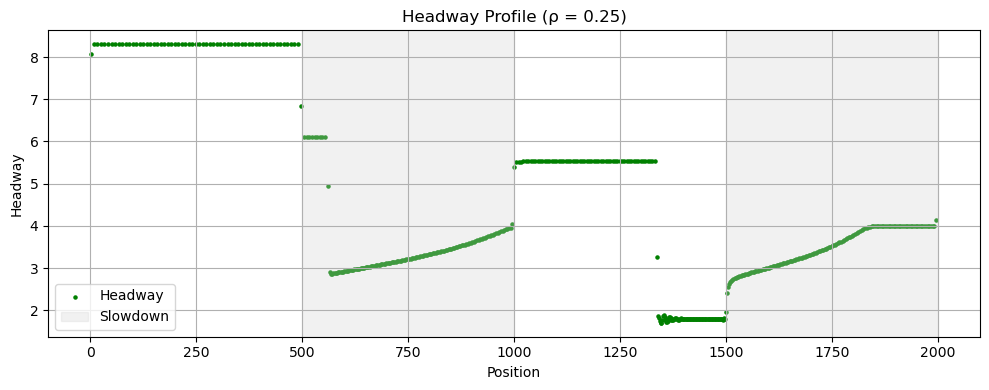

[INFO] Vẽ biểu đồ velocity profile...


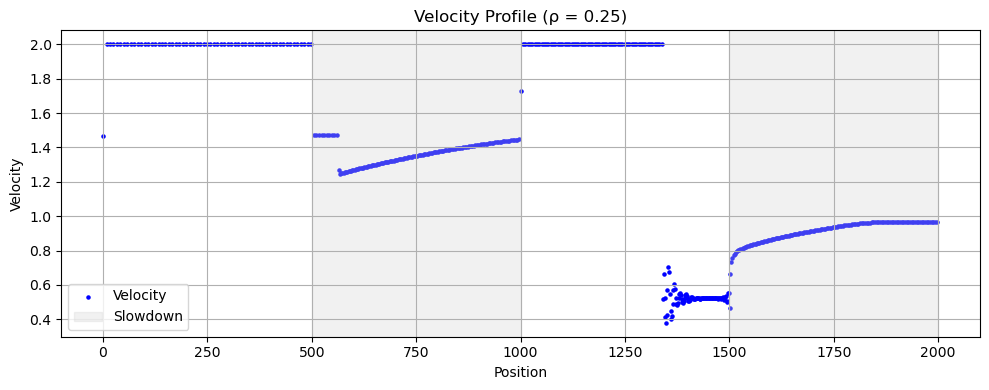

[INFO] Hoàn thành.


In [ ]:
# === THIẾT LẬP CHO FIGURE 8b ===

print("[INFO] Bắt đầu cấu hình mô phỏng...")

# Mật độ ρ = 0.25 khi N = 500, L = 2000 → headway = 1/ρ → L = N / 0.25
rho = 500 / 2000
dx_init = 1 / rho
L = N * dx_init

# === Cấu hình lại vị trí xe ban đầu ===
x_init = np.linspace(0, L - dx_init, N)
v_init = np.zeros(N)

# === 2 slowdown sections bằng nhau, N1 > N2 ===
sections = {
    'L': L,
    'slowdowns': [
        {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.5},
        {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
    ]
}

print(f"[INFO] Mô phỏng với N = {N}, L = {L:.2f}, ρ = {rho}, dx_init = {dx_init}")
print("[INFO] Bắt đầu chạy mô phỏng...")

# === CHẠY MÔ PHỎNG ===
history = simulate(
    N=N,
    steps=steps,
    dt=dt,
    acc_fn=acceleration,
    x_init=x_init,
    v_init=v_init,
    sections=sections,
    a=a,
    v_f_max=v_f_max,
    x_c=x_c,
    save_every=steps
)

print("[INFO] Mô phỏng hoàn tất.")

# === LẤY KẾT QUẢ ===
x_final, v_final = history[-1]

print("[INFO] Vẽ biểu đồ headway profile...")
plot_headway(x_final, sections, title=f"Headway Profile (ρ = {rho})")

print("[INFO] Vẽ biểu đồ velocity profile...")
plot_velocity(x_final, v_final, sections, title=f"Velocity Profile (ρ = {rho})")

print("[INFO] Hoàn thành.")

[INFO] Bắt đầu cấu hình mô phỏng...
[INFO] Mô phỏng với N = 500, L = 1500.00, ρ = 0.3333333333333333, dx_init = 3.0
[INFO] Bắt đầu chạy mô phỏng...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 1500.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[INFO] Mô phỏng hoàn tất.
[INFO] Vẽ biểu đồ headway profile...


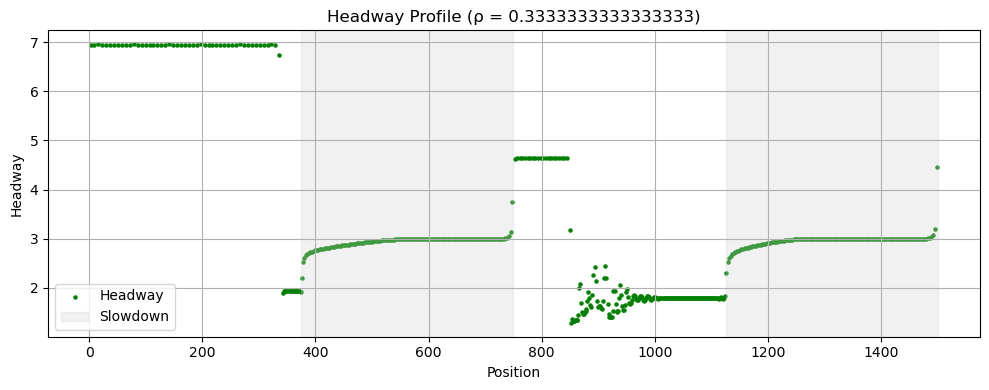

[INFO] Vẽ biểu đồ velocity profile...


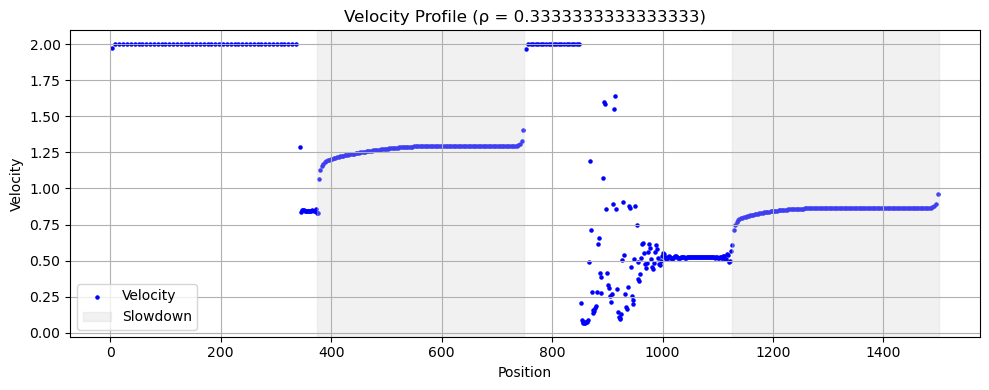

[INFO] Hoàn thành.


In [ ]:
# === THIẾT LẬP CHO FIGURE 8c ===

print("[INFO] Bắt đầu cấu hình mô phỏng...")

# Mật độ ρ = 0.33 khi N = 500, L = 1500 → headway = 1/ρ → L = N / 0.33
rho = 500 / 1500
dx_init = 1 / rho
L = N * dx_init

# === Cấu hình lại vị trí xe ban đầu ===
x_init = np.linspace(0, L - dx_init, N)
v_init = np.zeros(N)

# === 2 slowdown sections bằng nhau, N1 > N2 ===
sections = {
    'L': L,
    'slowdowns': [
        {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.5},
        {'start': 0.75 * L, 'end': 1.0 * L, 'v_max': 1.0}
    ]
}

print(f"[INFO] Mô phỏng với N = {N}, L = {L:.2f}, ρ = {rho}, dx_init = {dx_init}")
print("[INFO] Bắt đầu chạy mô phỏng...")

# === CHẠY MÔ PHỎNG ===
history = simulate(
    N=N,
    steps=steps,
    dt=dt,
    acc_fn=acceleration,
    x_init=x_init,
    v_init=v_init,
    sections=sections,
    a=a,
    v_f_max=v_f_max,
    x_c=x_c,
    save_every=steps
)

print("[INFO] Mô phỏng hoàn tất.")

# === LẤY KẾT QUẢ ===
x_final, v_final = history[-1]

print("[INFO] Vẽ biểu đồ headway profile...")
plot_headway(x_final, sections, title=f"Headway Profile (ρ = {rho})")

print("[INFO] Vẽ biểu đồ velocity profile...")
plot_velocity(x_final, v_final, sections, title=f"Velocity Profile (ρ = {rho})")

print("[INFO] Hoàn thành.")

## Configuration 6 - Figure 10a:
LS1 = LS2 = LS3 = LN1 = LN2 = LN3 = L/6

[INFO] Simulating jam length ratio for Figure 10a...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (7

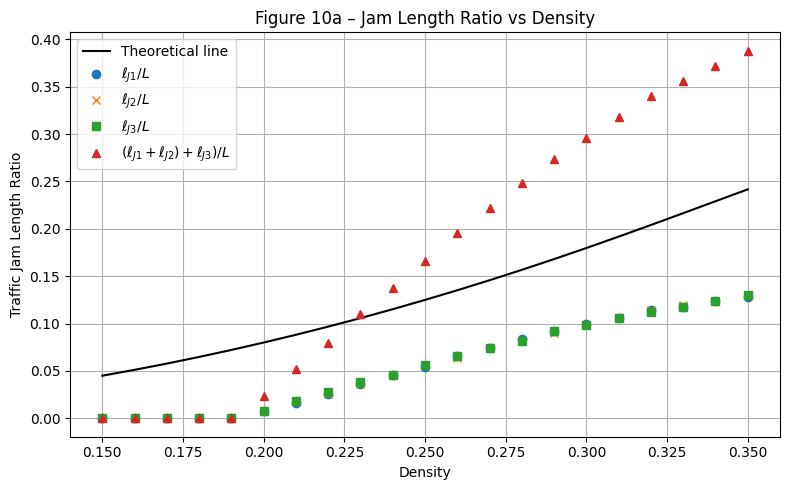

In [ ]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ3_list, lJ_total_list = [], [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 10a...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LN1 = LN2 = LN3 = LS1 = LS2 = LS3 = L/6
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 1/6 * L, 'end': 1/3 * L, 'v_max': 1.0},
            {'start': 1/2 * L, 'end': 2/3 * L, 'v_max': 1.0},
            {'start': 5/6 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2, j3 = 0, 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 1/6 * L:
                j1 += 1
            elif 1/3 * L <= pos <= 1/2 * L:
                j2 += 1
            elif 2/3 * L <= pos <= 5/6 * L:
                j3 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ3 = j3 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ3_list.append(lJ3 / L)
    lJ_total_list.append((lJ1 + lJ2 + lJ3) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ3_list, 's', label=r"$\ell_{J3}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})+\ell_{J3})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 10a – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## Configuration 7 - Figure 10b:
LS1 = LN1 = L/4, LS2 = LN2 = 0.15L, LS3 = LN3 = L/10

[INFO] Simulating jam length ratio for Figure 10b...
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3333.3333333333335 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (70%)
[SIM] Đang chạy... 40001/50000 (80%)
[SIM] Đang chạy... 45001/50000 (90%)
[SIM] Bước 50000/50000 đã lưu trạng thái.
[SIM] Mô phỏng hoàn tất.
[SIM] Bắt đầu mô phỏng trong 50000 bước...
[SIM] Số xe: 500 | Độ dài đường: 3125.0 | save_every: 50000
[SIM] Bước 1/50000 đã lưu trạng thái.
[SIM] Đang chạy... 5001/50000 (10%)
[SIM] Đang chạy... 10001/50000 (20%)
[SIM] Đang chạy... 15001/50000 (30%)
[SIM] Đang chạy... 20001/50000 (40%)
[SIM] Đang chạy... 25001/50000 (50%)
[SIM] Đang chạy... 30001/50000 (60%)
[SIM] Đang chạy... 35001/50000 (7

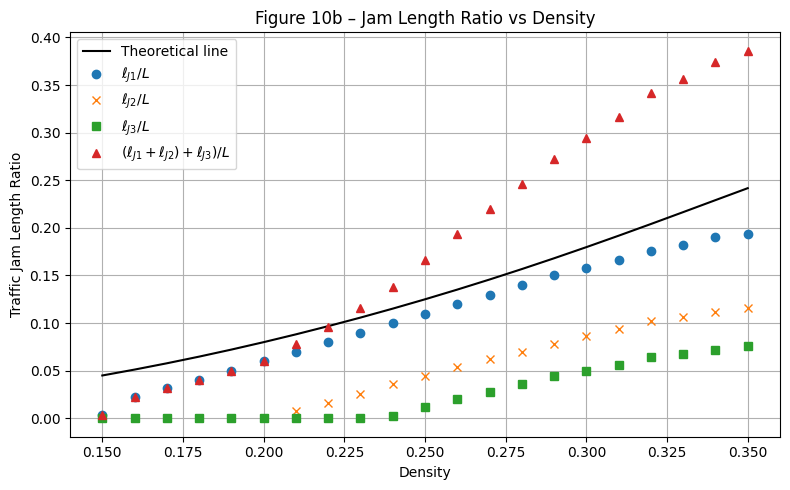

In [11]:
density_list = np.linspace(0.15, 0.35, 21)

lJ1_list, lJ2_list, lJ3_list, lJ_total_list = [], [], [], []
J_theory_list = []

print("[INFO] Simulating jam length ratio for Figure 10b...")

for i, rho in enumerate(density_list):
    dx = 1 / rho
    L = N * dx
    x_init = np.linspace(0, L - dx, N)
    v_init = np.zeros(N)

    # CẤU HÌNH: LS1 = LN1 = L/4, LS2 = LN2 = 0.15L, LS3 = LN3 = L/10
    sections = {
        'L': L,
        'slowdowns': [
            {'start': 0.25 * L, 'end': 0.5 * L, 'v_max': 1.0},
            {'start': 0.65 * L, 'end': 0.8 * L, 'v_max': 1.0},
            {'start': 0.9 * L, 'end': 1.0 * L, 'v_max': 1.0}
        ]
    }

    history = simulate(N=N, steps=steps, dt=dt, acc_fn=acceleration,
                       x_init=x_init, v_init=v_init,
                       sections=sections, a=a,
                       v_f_max=v_f_max, x_c=x_c,
                       save_every=steps)
    
    x_final, v_final = history[-1]
    dx_vehicle = L / N
    threshold = 0.8
    j1, j2, j3 = 0, 0, 0

    for xi, vi in zip(x_final, v_final):
        if vi < threshold:
            pos = xi % L
            if 0.0 * L <= pos <= 0.25 * L:
                j1 += 1
            elif 0.5 * L <= pos <= 0.65 * L:
                j2 += 1
            elif 0.8 * L <= pos <= 0.9 * L:
                j3 += 1

    lJ1 = j1 * dx_vehicle
    lJ2 = j2 * dx_vehicle
    lJ3 = j3 * dx_vehicle
    lJ1_list.append(lJ1 / L)
    lJ2_list.append(lJ2 / L)
    lJ3_list.append(lJ3 / L)
    lJ_total_list.append((lJ1 + lJ2 + lJ3) / L)

    # Tính lý thuyết J = V/Δx với v_max = v_f_max
    V_fn = get_theoretical_current_fn(v_max=v_f_max, x_c=x_c, a=a)
    J_theory_list.append(V_fn(dx) / dx)

print("[INFO] Mô phỏng hoàn tất. Đang vẽ biểu đồ...")

# ==== VẼ ====
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(density_list, J_theory_list, 'k-', label="Theoretical line")
ax.plot(density_list, lJ1_list, 'o', label=r"$\ell_{J1}/L$")
ax.plot(density_list, lJ2_list, 'x', label=r"$\ell_{J2}/L$")
ax.plot(density_list, lJ3_list, 's', label=r"$\ell_{J3}/L$")
ax.plot(density_list, lJ_total_list, '^', label=r"($\ell_{J1}+\ell_{J2})+\ell_{J3})/L$")

ax.set_xlabel("Density")
ax.set_ylabel("Traffic Jam Length Ratio")
ax.set_title("Figure 10b – Jam Length Ratio vs Density")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()